In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns

In [2]:
import matplotlib.ticker as ticker
from scipy.ndimage import median_filter
from scipy.interpolate import griddata

In [3]:
connectivity_min, connectivity_max = 0,15
delay_min, delay_max = 0,5
# random_input_span = (1.2,2.8)
random_input_span = (9.5,9.5)
total_time = 100
alpha = 100
alpha_folder = 'alpha_' + str(alpha)

current_models = ['IF','Rotational','Non_repulsive_rotational']
neuron_model = current_models[2]

model_folder_name = neuron_model+'_ensembles'
version = '_v2.0'
# version = '_v1.0'
# version = '_cluster_computed'

# Capture related ensembles

In [4]:
def list_folders_in_path(path):
    return [ name for name in os.listdir( path ) if os.path.isdir( os.path.join(path, name) ) ]

In [5]:
num_neurons = 10000
target_networks_name = 'N{}_T{}_I{}_{}'.format(num_neurons,total_time,random_input_span[0],random_input_span[1]) + version
target_path = os.path.join(model_folder_name,target_networks_name)
all_g_folders = list_folders_in_path(target_path)
desired_g_folders = all_g_folders

# delay_folder_name = 'd_{}'.format(delay)

In [6]:
sigma_glossary_dict = {}
amin_saman_param_glossary_dict = {}
field_period_glossary_dict = {}
field_max_intensity_mod_glossary_dict = {}

In [7]:
for g_folder in desired_g_folders:
    available_d_folders = list_folders_in_path(os.path.join(target_path,g_folder))

    g = float( g_folder.split('_')[1] ) #folder names are g_# d_#
    
    if g > connectivity_max or g < connectivity_min: continue #check if this connectivity is requested
    
    sigma_glossary_dict[g] = {}
    amin_saman_param_glossary_dict[g] = {}
    field_period_glossary_dict[g] = {}
    field_max_intensity_mod_glossary_dict[g] = {}
    
    for d_folder in available_d_folders:
        delay = float( d_folder.split('_')[1] ) #folder names are d_#
        if delay > delay_max or delay < delay_min: continue #check if this connectivity is requested
        g_d_alpha_path = os.path.join(target_path, g_folder, d_folder, alpha_folder)

        try:
            g_ensembles_list = list_folders_in_path(g_d_alpha_path)
            
            sigma_glossary_dict[g].update( {delay:[]} )
            amin_saman_param_glossary_dict[g].update( {delay:[]} )
            field_period_glossary_dict[g].update( {delay:[]} )
            field_max_intensity_mod_glossary_dict[g].update( {delay:[]} )
        except: #if the given connectivity and delay has not been measured even once
            continue

        for ensemble_num in g_ensembles_list:
            ensemble_path = os.path.join(g_d_alpha_path, ensemble_num)
            with open( os.path.join(ensemble_path,'sigma.txt') ) as file:
                sigma = float( file.readline() )
                sigma_glossary_dict[g][delay].append( sigma )

            with open( os.path.join(ensemble_path,'field_properties.txt') ) as file:
                info_line = file.readline()
                field_period = float( info_line.split(',')[0] )
                max_intensity_mod = float( info_line.split(',')[1] )
                field_period_glossary_dict[g][delay].append( field_period )
                field_max_intensity_mod_glossary_dict[g][delay].append( max_intensity_mod )

            if neuron_model in ['Rotational','Non_repulsive_rotational']: #if not does not exist
                with open( os.path.join(ensemble_path,'amin_saman_param.txt') ) as file:
                    amin_saman_param = float( file.readline() )        
                    amin_saman_param_glossary_dict[g][delay].append( amin_saman_param )        


        sigma_glossary_dict[g][delay] = np.mean(sigma_glossary_dict[g][delay])
        field_period_glossary_dict[g][delay] = np.mean(np.abs( field_period_glossary_dict[g][delay] ) )
        field_max_intensity_mod_glossary_dict[g][delay] = np.mean(field_max_intensity_mod_glossary_dict[g][delay])
        if neuron_model in ['Rotational','Non_repulsive_rotational']:amin_saman_param_glossary_dict[g][delay] = np.mean(amin_saman_param_glossary_dict[g][delay])


In [8]:
def dict_to_dataframe(input_dict):
    table = pd.DataFrame.from_dict(input_dict)
    table.index.name = 'delay'
    table.columns.name = 'connectivity'
    table = table.sort_index(axis=1)
    return table

def nested_dict_to_vectors(given_dict):
    coordinates = []
    for x in given_dict:
        for y in given_dict[x]:
            coordinates.append([x,y,given_dict[x][y]])
    return np.array(coordinates).T

def create_contour_phase_space(given_dict, title, plot_points = False):
    fig = plt.figure()
    ax = fig.add_subplot()
    
    grid_x, grid_y = np.mgrid[g_arr[0]:g_arr[-1]:500j, delay_arr[0]:delay_arr[-1]:500j]
    
    points = nested_dict_to_vectors(given_dict)[0:2].T
    values = nested_dict_to_vectors(given_dict)[2]
    grid_z = griddata(points, values, (grid_x, grid_y), method='linear')

    extent = [min(g_arr),max(g_arr),min(delay_arr),max(delay_arr)]    
    
    filtered_grid = median_filter(grid_z.T, size = 20)
    
    ax.contourf(filtered_grid, extent = extent, cmap = 'inferno')
    C = ax.contour(filtered_grid, extent = extent, colors='black', linewidth=.5)
    ax.clabel(C, inline=1, fontsize=10)
    
    if plot_points == True: ax.plot(points[:,0], points[:,1], 'w.', ms=1)
    
    ax.set_title('{} phase space'.format(title))
    ax.set_xlabel('Connectivity')
    ax.set_ylabel('Delay (s)')
    plt.close()
    return fig

In [9]:
# params = {"ytick.color" : "w",
#           "xtick.color" : "w",
#           "axes.labelcolor" : "w",
#           "axes.edgecolor" : "w"}
# plt.rcParams.update(params)

In [10]:
sigma_table = dict_to_dataframe(sigma_glossary_dict)
g_arr = np.sort( sigma_table.columns )
delay_arr = np.sort( sigma_table.index )

In [11]:
sns.set_theme(context='paper', font= 'Serif', style = 'ticks')

# Sigma dataframe

In [12]:
sigma_table = dict_to_dataframe(sigma_glossary_dict)
sigma_table.head()

connectivity,0.0,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,...,10.5,11.0,11.5,12.0,12.5,13.0,13.5,14.0,14.5,15.0
delay,,,,,,,,,,,,,,,,,,,,,
0.10,0.519862,0.506833,0.469618,0.425130,0.365581,0.465949,0.256227,0.258400,0.488492,0.620876,...,0.789965,0.777520,0.771762,0.771522,0.767047,0.758893,0.755232,0.750658,0.747525,0.740177
0.25,0.122178,0.119987,0.110900,0.114839,0.113890,0.126747,0.107750,0.121302,0.121385,0.127591,...,0.730995,0.725526,0.720838,0.717854,0.712503,0.704850,0.704391,0.699226,0.694062,0.690957
0.50,0.114052,0.110032,0.107749,0.110759,0.106663,0.116852,0.109746,0.113577,0.135514,0.138037,...,0.733647,0.729305,0.724703,0.717996,0.710101,0.710116,0.703176,0.702925,0.691287,0.690740
0.75,0.116661,0.122217,0.114295,0.114193,0.107123,0.103674,0.114675,0.109083,0.139725,0.156492,...,0.733249,0.732763,0.720711,0.718413,0.714795,0.710737,0.707223,0.700936,0.697328,0.690968
1.00,0.120265,0.125232,0.117213,0.105586,0.105413,0.099211,0.118651,0.069146,0.128173,0.133220,...,0.732643,0.725807,0.723600,0.716716,0.720909,0.712825,0.707730,0.700017,0.691418,0.696579


C:\Users\mohsen\AppData\Local\Temp/ipykernel_6508/2442720307.py:7: MatplotlibDeprecationWarning: 
The IndexFormatter class was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  ax_sigma.yaxis.set_major_formatter(ticker.IndexFormatter(yticklabels))


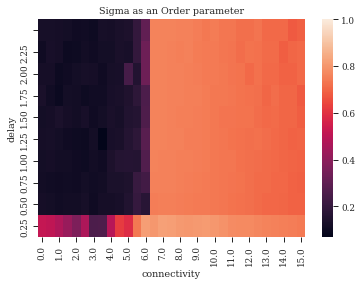

In [13]:
yticklabels = ['{:.2f}'.format(x) for x in sigma_table.index.to_list()]
ax_sigma = sns.heatmap(sigma_table, annot=False, vmax = 1)

ax_sigma.set_title('Sigma as an Order parameter')
ax_sigma.invert_yaxis()

ax_sigma.yaxis.set_major_formatter(ticker.IndexFormatter(yticklabels))

In [14]:
fig = ax_sigma.get_figure()
fig.savefig(os.path.join(target_path, 'sigma_phase_space.png'), dpi = 1000)

C:\Users\mohsen\AppData\Local\Temp/ipykernel_6508/891229783.py:30: UserWarning: The following kwargs were not used by contour: 'linewidth'
  C = ax.contour(filtered_grid, extent = extent, colors='black', linewidth=.5)


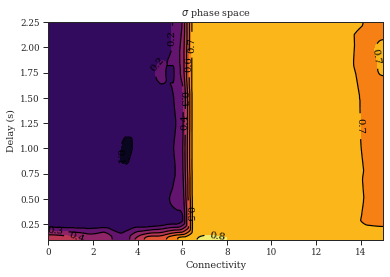

In [15]:
c_fig = create_contour_phase_space(sigma_glossary_dict, r'$\sigma$')
c_fig.savefig(os.path.join(target_path, 'sigma_phase_space_contour.png'), dpi = 1000)
c_fig

C:\Users\mohsen\AppData\Local\Temp/ipykernel_6508/891229783.py:30: UserWarning: The following kwargs were not used by contour: 'linewidth'
  C = ax.contour(filtered_grid, extent = extent, colors='black', linewidth=.5)


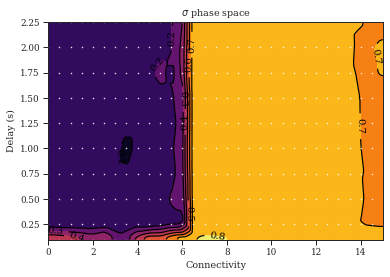

In [16]:
c_fig = create_contour_phase_space(sigma_glossary_dict, r'$\sigma$', plot_points = True)
c_fig.savefig(os.path.join(target_path, 'sigma_phase_space_contour_points_plotted.png'), dpi = 1000)
c_fig

# Amin Saman Parameter

C:\Users\mohsen\AppData\Local\Temp/ipykernel_6508/891229783.py:30: UserWarning: The following kwargs were not used by contour: 'linewidth'
  C = ax.contour(filtered_grid, extent = extent, colors='black', linewidth=.5)


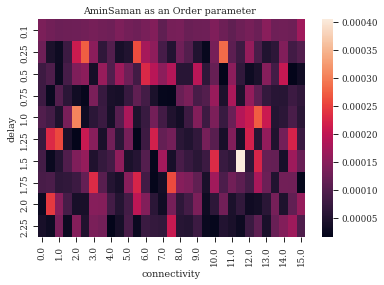

In [17]:
if neuron_model in ['Rotational','Non_repulsive_rotational']:
    amin_saman_param_table = dict_to_dataframe(amin_saman_param_glossary_dict)
    ax_field_period = sns.heatmap(amin_saman_param_table)
    ax_field_period.set_title('AminSaman as an Order parameter ')
    fig = ax_field_period.get_figure()
    fig.savefig(os.path.join(target_path, 'amin_saman_phase_space.png'))
    
    create_contour_phase_space(amin_saman_param_glossary_dict, 'AminSaman').savefig(os.path.join(target_path, 'amin_saman_phase_space_contour.png'), dpi = 1000)

# Field period dataframe

In [18]:
field_period_table = dict_to_dataframe(field_period_glossary_dict)
field_period_table.head()

connectivity,0.0,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,...,10.5,11.0,11.5,12.0,12.5,13.0,13.5,14.0,14.5,15.0
delay,,,,,,,,,,,,,,,,,,,,,
0.10,0.020125,0.025873,0.034329,0.047985,0.073855,0.034014,0.201613,0.047059,0.026667,0.026695,...,0.316456,0.319489,0.328947,0.342466,0.352113,0.362319,0.370370,0.381679,0.395257,0.401606
0.25,0.031496,0.050994,0.036510,0.043122,0.022356,0.462963,0.020790,0.114416,0.032798,0.051600,...,0.740741,0.763359,0.787402,0.806452,0.826446,0.854701,0.869565,0.892857,0.917431,0.934579
0.50,0.033069,0.357143,0.028393,0.051203,0.096899,0.071124,0.042481,0.093633,0.154560,1.136364,...,1.408451,1.449275,1.492537,1.538462,1.587302,1.612903,1.666667,1.694915,1.754386,1.785714
0.75,0.030066,0.032457,0.047916,0.068259,0.037908,0.057770,0.023267,0.029438,0.120337,0.042034,...,2.083333,2.127660,2.222222,2.272727,2.325581,2.380952,2.439024,2.500000,2.564103,2.631579
1.00,0.031496,0.050994,0.058962,0.022143,0.436681,0.071124,0.036193,2.127660,0.108225,0.066756,...,2.777778,2.857143,2.941176,3.030303,3.030303,3.125000,3.225806,3.333333,3.448276,3.448276


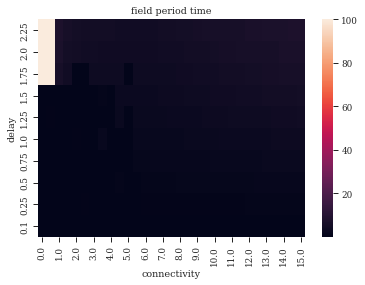

In [19]:
# ax_field_period = sns.heatmap(np.log(field_period_table.abs()), annot=False, vmax = 2, vmin = -2)
ax_field_period = sns.heatmap(field_period_table.abs(), annot=False)
ax_field_period.set_title('field period time')
ax_field_period.invert_yaxis()

In [20]:
fig = ax_field_period.get_figure()
fig.savefig(os.path.join(target_path, 'field_period_phase_space.png'))

C:\Users\mohsen\AppData\Local\Temp/ipykernel_6508/891229783.py:30: UserWarning: The following kwargs were not used by contour: 'linewidth'
  C = ax.contour(filtered_grid, extent = extent, colors='black', linewidth=.5)


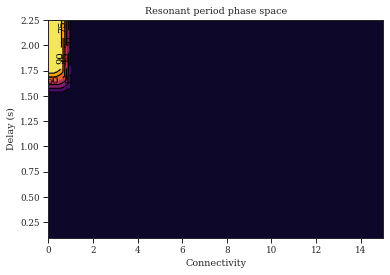

In [21]:
c_fig = create_contour_phase_space(field_period_table.abs().to_dict(), 'Resonant period')
c_fig.savefig(os.path.join(target_path, 'field_period_phase_space_contour.png'), dpi = 1000)
c_fig

In [22]:
max_intensity_table = dict_to_dataframe(field_max_intensity_mod_glossary_dict)
max_intensity_table.head()

connectivity,0.0,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,...,10.5,11.0,11.5,12.0,12.5,13.0,13.5,14.0,14.5,15.0
delay,,,,,,,,,,,,,,,,,,,,,
0.10,2160.069208,2840.791503,2100.330536,1642.925258,1000.947744,1674.187896,434.196386,374.917165,963.029804,1951.320901,...,4387.865658,4019.436865,2955.269143,2854.916333,3206.049030,3024.015276,2587.349275,2837.923819,3269.179802,3633.779284
0.25,229.443889,196.322537,202.778227,191.030581,242.141859,288.517168,165.302607,238.158339,292.004047,301.327803,...,4047.377459,4073.765167,4060.089267,3709.726510,3002.942716,2666.395964,3286.955077,3401.411821,3864.230612,3216.600321
0.50,246.133537,233.594444,198.908642,247.457730,265.927115,217.405201,204.232709,200.614154,277.517762,415.320112,...,4402.760622,4262.862507,4295.577355,4117.410555,3119.106681,3868.802672,3705.465228,3604.808682,3275.479125,3844.637975
0.75,206.800158,195.240150,217.777339,213.159534,230.364962,179.101060,262.584850,190.925054,292.642507,382.381247,...,4350.450832,3867.804912,3055.092640,4005.060754,4167.389838,4070.945610,3922.111247,3914.891159,3848.992158,3849.326051
1.00,212.171927,223.298619,213.716861,171.552569,240.183370,237.154348,308.266802,147.892532,214.506596,217.174966,...,3261.337939,3490.421273,3419.604214,2961.383187,2942.093099,3649.401611,3993.422268,3793.894677,2801.207195,3405.869156


C:\Users\mohsen\AppData\Local\Temp/ipykernel_6508/891229783.py:30: UserWarning: The following kwargs were not used by contour: 'linewidth'
  C = ax.contour(filtered_grid, extent = extent, colors='black', linewidth=.5)


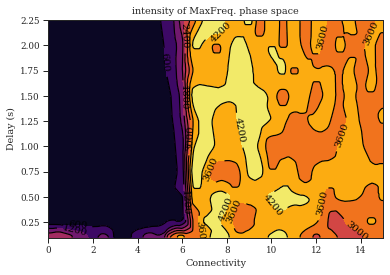

In [23]:
c_fig = create_contour_phase_space(field_max_intensity_mod_glossary_dict, 'intensity of MaxFreq.')
c_fig.savefig(os.path.join(target_path, 'max_intensity_phase_space_contour.png'), dpi = 1000)
c_fig

In [24]:
# %matplotlib notebook
# from mpl_toolkits.mplot3d import Axes3D

# d_arr = max_intensity_table.index
# g_arr = max_intensity_table.columns
# bars_pos = np.array([np.tile(g_arr, len(d_arr)), np.repeat(d_arr, len(g_arr)), [0]*(len(d_arr)*len(g_arr))])

# dd_arr = d_arr[1] - d_arr[0]
# dg_arr = g_arr[1] - g_arr[0]

# dmax_intensity = max_intensity_table.to_numpy().flatten()

# cmap = plt.cm.get_cmap('magma') # Get desired colormap - you can change this!
# period_arr = field_period_table.to_numpy().flatten()
# max_height = np.max(period_arr)   # get range of colorbars so we can normalize
# min_height = np.min(period_arr)
# # scale each z to [0,1], and get their rgb values
# rgba = [cmap( np.log( k ) ) for k in period_arr] 


# fig = plt.figure()          #create a canvas, tell matplotlib it's 3d
# # ax = fig.add_subplot(111, projection='3d')
# # ax.bar3d(bars_pos[0], bars_pos[1], bars_pos[2], dg_arr, dd_arr, dmax_intensity, color=rgba)